<a href="https://colab.research.google.com/github/fkhandley/msds6925/blob/main/MSDS6825_practicum_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries and data files saved in Google Drive

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import MinMaxScaler
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dtype_dict = {
    'order_id': 'string',
    'user_id': 'string',
    'payment_method': 'category',
    'user_zipcode_current': 'category',
    'gender': 'category',
    'product_category': 'category',
    'strain_type': 'category'
}

In [5]:
orders_load = pd.read_csv('/content/drive/MyDrive/orders.csv', dtype=dtype_dict)

# Data Sampling

The model trains fast without much data on this simple proof of concept structure. With more complex models we may choose to train more epochs and will need more data.  To reduce the amount of compute in pre processing, we sample users her first.  50% was more than was needed.

In [6]:
orders_load['delivery_datetime'] = pd.to_datetime(orders_load['delivery_datetime'])

In [7]:
user_orders = orders_load.groupby('user_id').size().reset_index(name='order_count')
print(f"Original number of unique users: {len(user_orders)}")
user_orders5 = user_orders[user_orders['order_count'] >= 5]
print(f"Users with 5+ orders: {len(user_orders5)}")
users5 = user_orders5['user_id'].unique()
user_size = round(len(users5)*0.5,0)
print(f"Taking sample of {user_size} users")
user_sample = np.random.choice(users5, size=int(user_size), replace=False)
orders_load = orders_load[orders_load['user_id'].isin(user_sample)]
final_orders_per_user = orders_load.groupby('user_id').size()
print("\nFinal orders per user:")
print(final_orders_per_user.describe())

Original number of unique users: 884901
Users with 5+ orders: 265985
Taking sample of 132992.0 users

Final orders per user:
count    132992.000000
mean         20.929146
std          28.016473
min           5.000000
25%           7.000000
50%          11.000000
75%          23.000000
max         786.000000
dtype: float64


# Feature Engineering

Days since last order along with average days since last order are key inputs into the model.  We will be building rolling sequences of orders so days since order needs to be calculated for each order.  Average days between orders will be calculated in the data generator to prevent any data leakage issues.

We'll also create the user age at time of order and the user account age at time of order. These are not as important, but there is some learning on how users change behavior as they mature into the customer base.

In [8]:
freq_df = orders_load[['order_id','user_id','delivery_datetime']].copy()
freq_df.drop_duplicates('order_id', inplace=True)
freq_df.sort_values('delivery_datetime', inplace=True)

# Create the shifted dates within each user group
freq_df['last_delivery_date'] = freq_df.groupby('user_id')['delivery_datetime'].shift(1)

# Calculate the days between orders
freq_df['days_since_order'] = (freq_df['delivery_datetime'] - freq_df['last_delivery_date']).dt.days

In [9]:
orders_load = orders_load.merge(freq_df[['order_id','days_since_order']], on='order_id', how='left')

In [10]:
del freq_df

# Key input: days of orders lookback

In [11]:
users_load = pd.read_csv('/content/drive/MyDrive/users.csv', dtype=dtype_dict)

In [12]:
orders = orders_load.merge(users_load, on='user_id', how='left')

In [13]:
del orders_load

In [14]:
del users_load

In [15]:
orders = orders.drop('promo_code', axis=1)
orders['account_created_at'] = pd.to_datetime(orders['account_created_at'])
orders['birthdate'] = pd.to_datetime(orders['birthdate'])

In [16]:
orders['age_at_purchase'] = round(orders.delivery_datetime.dt.year - orders.birthdate.dt.year)

orders['account_age_at_purchase'] =  (orders.delivery_datetime.dt.year - orders.account_created_at.dt.year)*12+orders.delivery_datetime.dt.month - orders.account_created_at.dt.month

In [17]:
fill_values = {
    'wait_time': orders['wait_time'].mean(),
    'days_since_order': 0,
    'edibles': 0,
    'flower': 0,
    'prerolls': 0,
    'vaporizers': 0,
    'age_at_purchase': orders['age_at_purchase'].mean()
    }

orders = orders.fillna(fill_values)

In [18]:
orders_final = orders.drop(['order_id','account_created_at','birthdate','gender','payment_method','wait_time'], axis=1).copy()

In [19]:
orders_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2783409 entries, 0 to 2783408
Data columns (total 8 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   user_id                  string        
 1   delivery_datetime        datetime64[ns]
 2   promo_credit             float64       
 3   order_price_total        float64       
 4   days_since_order         float64       
 5   user_zipcode_current     category      
 6   age_at_purchase          float64       
 7   account_age_at_purchase  int64         
dtypes: category(1), datetime64[ns](1), float64(4), int64(1), string(1)
memory usage: 155.2 MB


In [20]:
user_count = orders_final.user_id.nunique()
user_count

132992

# Deep Learning START

In [21]:
# Ensure use of GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        # Configure GPU memory growth
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU memory growth enabled")

        # Set mixed precision policy
        tf.keras.mixed_precision.set_global_policy('mixed_float16')
        print("Mixed precision policy set to float16")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1
GPU memory growth enabled
Mixed precision policy set to float16


# Data generators & train/val split

Training and validaiton data are split by user instead of time.  It was deemed more important for the model to generalize to all users than all time periods.  This also allows the model to train on more recent data.  A 80/20 split of users was applied for train/val randomly.

The generators sample the train or val data at 2% to speed up processing and then generate sequences for each user.  A weak point of this current model is that is over trains on selected users however it does shuffle all the generated sequences in each generation process which helps prevent over fitting to those users.  Most sequences generated are never used due to the large data set and small epochs.

Sequence length is 10 orders with a minimum of 5 orders.



In [22]:
class OrderSequenceGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, sequence_length=10, min_orders=5, batch_size=32, user_sample_fraction=0.02):
        super().__init__()
        self.df = df
        self.sequence_length = sequence_length
        self.min_orders = min_orders
        self.batch_size = batch_size

        # Group by user and filter for users with minimum orders
        self.user_orders = {}
        user_counts = df.groupby('user_id').size()
        valid_users = user_counts[user_counts >= min_orders].index.tolist()

        # Take a sample of users for faster processing
        sample_size = max(100, int(len(valid_users) * user_sample_fraction))
        self.users = np.random.choice(valid_users, sample_size, replace=False)

        # Cache user data
        for user_id in self.users:
            self.user_orders[user_id] = df[df['user_id'] == user_id].sort_values('delivery_datetime')

        # Calculate total number of sequences
        self.sequence_indices = self._calculate_sequence_indices()
        self.steps = len(self.sequence_indices) // batch_size

    def _calculate_sequence_indices(self):
        """Pre-calculate all valid (user_id, start_idx) pairs"""
        sequence_indices = []
        for user_id in self.users:
            user_data = self.user_orders[user_id]

            # No split needed here as data is already split before generator creation
            if len(user_data) >= self.sequence_length:
                for i in range(len(user_data) - self.sequence_length + 1):
                    sequence_indices.append((user_id, i))

        return sequence_indices

    def __len__(self):
        return max(1, len(self.sequence_indices) // self.batch_size)

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.sequence_indices))
        batch_indices = self.sequence_indices[start_idx:end_idx]

        batch_sequences = []
        batch_labels = []

        for user_id, seq_start in batch_indices:
            sequence, label = self._create_sequence(user_id, seq_start)
            if sequence is not None:
                batch_sequences.append(sequence)
                batch_labels.append(label)

        # Pad batch if needed
        if len(batch_sequences) < self.batch_size:
            pad_size = self.batch_size - len(batch_sequences)
            feature_dim = len(self.get_feature_names()) + 1  # +1 for sequence frequency
            batch_sequences.extend([np.zeros((self.sequence_length, feature_dim))] * pad_size)
            batch_labels.extend([0] * pad_size)

        return np.array(batch_sequences), np.array(batch_labels)

    def get_feature_names(self):
        return [
            'days_since_order',
            'order_price_total',
            'promo_credit',
            'account_age_at_purchase'
        ]

    def _create_sequence(self, user_id, start_idx):
        user_data = self.user_orders[user_id]
        sequence_data = user_data.iloc[start_idx:start_idx + self.sequence_length]

        if len(sequence_data) < self.sequence_length:
            return None, None

        # Calculate average frequency
        days_between = sequence_data['days_since_order'].dropna()
        if len(days_between) == 0:
            return None, None

        seq_freq = days_between.mean()
        features = self.get_feature_names()

        # Build sequence
        sequence = np.zeros((self.sequence_length, len(features) + 1))
        for j, order in enumerate(sequence_data.itertuples()):
            sequence[j, :-1] = [getattr(order, feat) for feat in features]
            sequence[j, -1] = seq_freq

        # Calculate label (order within next 7 days)
        last_order_date = sequence_data.iloc[-1]['delivery_datetime']
        next_week = last_order_date + pd.Timedelta(days=7)

        # Check for future orders
        future_order = user_data[
            (user_data['delivery_datetime'] > last_order_date) &
            (user_data['delivery_datetime'] <= next_week)
        ]

        label = 1 if len(future_order) > 0 else 0
        return sequence, label

    def on_epoch_end(self):
        # Shuffle sequence indices
        np.random.shuffle(self.sequence_indices)

# Model Design

This exercise was primarily a proof of concept, so a smaller and simpler model was used.  We're currently just predicting true/false if the customer will place an order over the next 7 days so sigmoid is used at the final layer and binary crossentropy was used for the loss function.  Originally we included regularization and dropout, but a test run without the dropout showed better results.  Also used a reducing learning rate, but we see the model does most of it's learning pretty fast. For this use case and regression model may be better, but there is an expectation of adding more data features that will make deep learning more effective.  Because of a large imbalance in the data, class weights were implemented

In [29]:
def create_lstm_model(sequence_length, n_features):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=(sequence_length, n_features)),

        # First LSTM layer with increased regularization
        layers.LSTM(64, return_sequences=True,
                   kernel_regularizer=tf.keras.regularizers.L2(0.01),
                   recurrent_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.BatchNormalization(),
        #layers.Dropout(0.2),

        # Second LSTM layer
        layers.LSTM(32, return_sequences=True,
                   kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.BatchNormalization(),
        #layers.Dropout(0.2),

        # Final LSTM layer
        layers.LSTM(16),
        layers.BatchNormalization(),
        #layers.Dropout(0.15),

        # Dense layers with reduced complexity
        layers.Dense(16, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        layers.BatchNormalization(),
        #layers.Dropout(0.15),

        # Output layer
        layers.Dense(1, activation='sigmoid')
    ])

    # Compile with modified learning rate and added clipnorm
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.0005,  # Reduced learning rate
        clipnorm=1.0  # Gradient clipping
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )

    return model

In [30]:
def train_model(df, sequence_length=10, batch_size=64, epochs=100):
    print("Starting training preparation...")

    # Split users into train and validation
    unique_users = df['user_id'].unique()
    np.random.seed(42)  # For reproducibility
    val_size = int(round(len(unique_users) * 0.2, 0))
    val_users = np.random.choice(unique_users, size=val_size, replace=False)
    train_users = [u for u in unique_users if u not in val_users]

    train_df = df[df['user_id'].isin(train_users)]
    val_df = df[df['user_id'].isin(val_users)]

    print(f"Training set users: {len(train_df['user_id'].unique())}")
    print(f"Validation set users: {len(val_df['user_id'].unique())}")

    # Create generators with progress tracking
    print("Preparing training generator...")
    start_time = time.time()
    train_generator = OrderSequenceGenerator(
        train_df,
        sequence_length=sequence_length,
        batch_size=batch_size,
    )
    print(f"Training generator ready in {time.time() - start_time:.2f} seconds")
    print(f"Training steps per epoch: {len(train_generator)}")

    print(f"Calculating training weights")
    pos_count = sum(1 for user_id, start_idx in train_generator.sequence_indices
                if train_generator._create_sequence(user_id, start_idx)[1] == 1)
    neg_count = len(train_generator.sequence_indices) - pos_count
    total = pos_count + neg_count

    # Create weight dictionary (higher weight for minority class)
    class_weights = {
        0: 1.0,
        1: (neg_count / pos_count) if pos_count > 0 else 9.0  # Fallback if no positives
        }
    print(f"Class weight set at:{class_weights}")

    print("Preparing validation generator...")
    start_time = time.time()
    val_generator = OrderSequenceGenerator(
        val_df,
        sequence_length=sequence_length,
        batch_size=batch_size
    )
    print(f"Validation generator ready in {time.time() - start_time:.2f} seconds")
    print(f"Validation steps per epoch: {len(val_generator)}")

    # Get feature dimensionality
    n_features = len(train_generator.get_feature_names()) + 1  # +1 for sequence frequency

    # Create model
    print(f"Creating LSTM model with {sequence_length} sequence length and {n_features} features...")
    model = create_lstm_model(sequence_length, n_features)

    # Add callbacks for early stopping and learning rate reduction, but no model saving
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        ),
        tf.keras.callbacks.TensorBoard(
            log_dir=f'./logs/lstm_model_{int(time.time())}',
            histogram_freq=1
        )
    ]

    # Train the model
    print(f"Starting training for {epochs} epochs...")
    start_time = time.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1
    )

    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

    # Return model and history without saving
    return model, history

In [31]:
# Run the training
model, history = train_model(orders_final)

Starting training preparation...
Training set users: 106394
Validation set users: 26598
Preparing training generator...
Training generator ready in 427.80 seconds
Training steps per epoch: 294
Calculating training weights
Class weight set at:{0: 1.0, 1: 2.346967810777165}
Preparing validation generator...
Validation generator ready in 26.73 seconds
Validation steps per epoch: 82
Creating LSTM model with 10 sequence length and 5 features...
Starting training for 100 epochs...
Epoch 1/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 54s 162ms/step - accuracy: 0.6649 - auc: 0.7419 - loss: 2.1669 - precision: 0.4651 - recall: 0.7403 - val_accuracy: 0.7702 - val_auc: 0.8090 - val_loss: 1.0782 - val_precision: 0.6136 - val_recall: 0.6407 - learning_rate: 5.0000e-04
Epoch 2/100
294/294 ━━━━━━━━━━━━━━━━━━━━ 45s 154ms/step - accuracy: 0.7464 - auc: 0.8223 - loss: 1.1998 - precision: 0.5588 - recall: 0.7548 - val_accuracy: 0.7736 - val_auc: 0.8270 - val_loss: 0.8038 - val_precision: 0.6061 - val_recall: 0.7074 

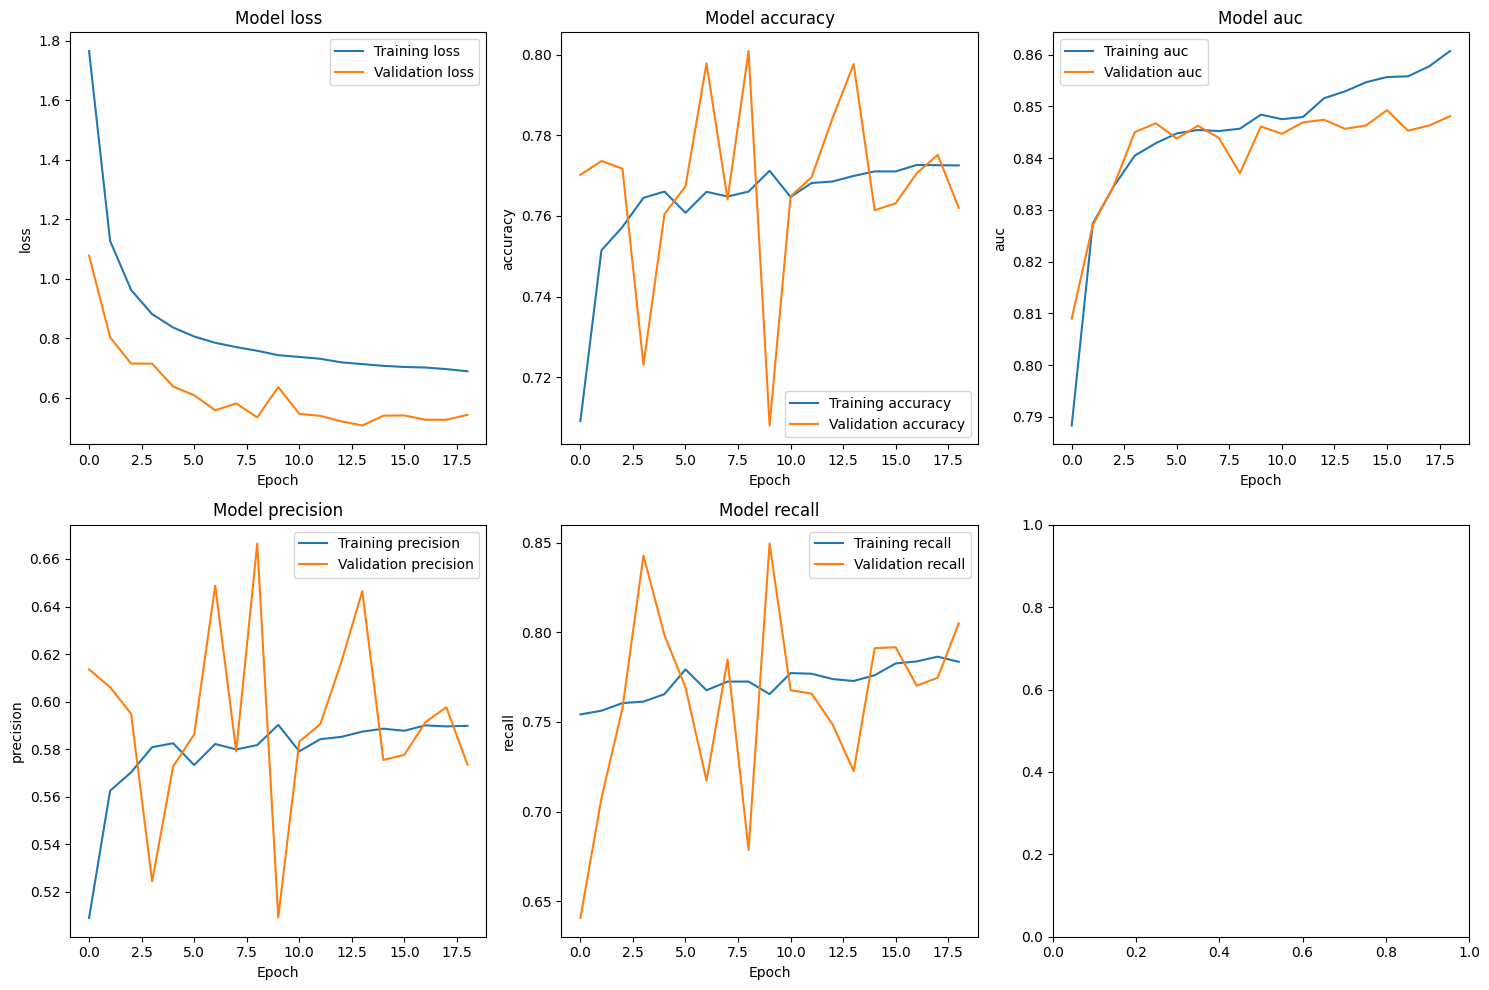


Final Training Metrics:
Loss: 0.6897
Accuracy: 0.7725
AUC: 0.8607
Precision: 0.5899
Recall: 0.7835

Final Validation Metrics:
Loss: 0.5433
Accuracy: 0.7620
AUC: 0.8481
Precision: 0.5736
Recall: 0.8050


In [32]:
# Plot the training results
def plot_training_metrics(history):
    metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics):
        if idx >= len(axes):
            break

        axes[idx].plot(history.history[metric], label=f'Training {metric}')
        axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[idx].set_title(f'Model {metric}')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric)
        axes[idx].legend()

    plt.tight_layout()
    plt.show()

# Plot the results
plot_training_metrics(history)

# Print final metrics
final_epoch = len(history.history['loss']) - 1
print("\nFinal Training Metrics:")
print(f"Loss: {history.history['loss'][final_epoch]:.4f}")
print(f"Accuracy: {history.history['accuracy'][final_epoch]:.4f}")
print(f"AUC: {history.history['auc'][final_epoch]:.4f}")
print(f"Precision: {history.history['precision'][final_epoch]:.4f}")
print(f"Recall: {history.history['recall'][final_epoch]:.4f}")

print("\nFinal Validation Metrics:")
print(f"Loss: {history.history['val_loss'][final_epoch]:.4f}")
print(f"Accuracy: {history.history['val_accuracy'][final_epoch]:.4f}")
print(f"AUC: {history.history['val_auc'][final_epoch]:.4f}")
print(f"Precision: {history.history['val_precision'][final_epoch]:.4f}")
print(f"Recall: {history.history['val_recall'][final_epoch]:.4f}")

In [33]:
import matplotlib.pyplot as plt
import os

# Create directory for saving plots if it doesn't exist
def create_plots_directory(directory='presentation_plots'):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

# Plot and save training metrics
def plot_training_metrics(history, save_dir='presentation_plots', dpi=300):
    metrics = ['loss', 'accuracy', 'auc', 'precision', 'recall']
    save_dir = create_plots_directory(save_dir)

    # Create individual plots for each metric with transparent background
    for idx, metric in enumerate(metrics):
        plt.figure(figsize=(8, 6))

        # Set figure with transparent background
        fig = plt.gcf()
        fig.patch.set_alpha(0.0)

        # Plot training and validation metrics
        plt.plot(history.history[metric], label=f'Training {metric}', linewidth=2)
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric}', linewidth=2)

        # Set title and labels
        plt.title(f'Model {metric.capitalize()}', fontsize=14, fontweight='bold')
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel(metric.capitalize(), fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle='--', alpha=0.7)

        # Set transparent axes background
        ax = plt.gca()
        ax.patch.set_alpha(0.0)

        # Save the plot with transparent background
        filename = os.path.join(save_dir, f'{metric}_plot.png')
        plt.savefig(filename, dpi=dpi, bbox_inches='tight', transparent=True)
        plt.close()

    # Create a summary figure with all metrics
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    # Set figure with transparent background
    fig.patch.set_alpha(0.0)

    for idx, metric in enumerate(metrics):
        if idx >= len(axes):
            break

        axes[idx].plot(history.history[metric], label=f'Training {metric}', linewidth=2)
        axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}', linewidth=2)
        axes[idx].set_title(f'Model {metric.capitalize()}', fontsize=12, fontweight='bold')
        axes[idx].set_xlabel('Epoch', fontsize=10)
        axes[idx].set_ylabel(metric.capitalize(), fontsize=10)
        axes[idx].legend(fontsize=8)
        axes[idx].grid(True, linestyle='--', alpha=0.7)

        # Set transparent axes background
        axes[idx].patch.set_alpha(0.0)

    plt.tight_layout()

    # Save the summary figure
    summary_filename = os.path.join(save_dir, 'all_metrics_summary.png')
    plt.savefig(summary_filename, dpi=dpi, bbox_inches='tight', transparent=True)
    plt.close()

    print(f"All plots saved to '{save_dir}' directory with transparent backgrounds")

    # Print final metrics in a summary table
    final_epoch = len(history.history['loss']) - 1

    print("\nFinal Training Metrics:")
    for metric in metrics:
        print(f"{metric.capitalize()}: {history.history[metric][final_epoch]:.4f}")

    print("\nFinal Validation Metrics:")
    for metric in metrics:
        print(f"{metric.capitalize()}: {history.history[f'val_{metric}'][final_epoch]:.4f}")

    return save_dir

# Example usage:
plot_training_metrics(history, save_dir='presentation_plots', dpi=300)

All plots saved to 'presentation_plots' directory with transparent backgrounds

Final Training Metrics:
Loss: 0.6897
Accuracy: 0.7725
Auc: 0.8607
Precision: 0.5899
Recall: 0.7835

Final Validation Metrics:
Loss: 0.5433
Accuracy: 0.7620
Auc: 0.8481
Precision: 0.5736
Recall: 0.8050


'presentation_plots'